In [3]:
from google.cloud import bigquery

client = bigquery.Client(project='datamanagementbi')
tabla_completa = 'datamanagementbi.gold_data.modelo_final'
tabla = client.get_table(tabla_completa)

query = """
    SELECT *
    FROM `datamanagementbi.gold_data.modelo_final`
"""

df = client.query(query).to_dataframe()

/opt/miniconda3/lib/python3.13/site-packages/google/auth/_default.py:108: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor

In [5]:
# ============================================================================
# ANÁLISIS SEGMENTADO POR SECTOR ECONÓMICO
# ============================================================================

print("🏭🏠🏢 ANÁLISIS SEGMENTADO POR SECTOR ECONÓMICO")
print("=" * 80)

# Mapeo de sectores
sector_map = {1: 'Industrial', 2: 'Residencial', 3: 'Servicios'}
df['Sector_nombre'] = df['id_sector_economico'].map(sector_map)

🏭🏠🏢 ANÁLISIS SEGMENTADO POR SECTOR ECONÓMICO



📊 1. PERFIL GENERAL DE CADA SECTOR

📈 Estadísticas por sector:
              consumo_kwh                                                 \
                    count         mean      median          std      min   
Sector_nombre                                                              
Industrial         358825   5086108.08   1450000.0  12615277.01   1000.0   
Residencial        360606  42356571.96  39201000.0  18998363.11   4000.0   
Servicios          360666  59356715.32  51952000.0  33348946.06  71000.0   

                           temperatura_media_ciudad poblacion  
                       max                     mean      mean  
Sector_nombre                                                  
Industrial     131138000.0                    17.71  23697.82  
Residencial    891516000.0                    17.75  23696.12  
Servicios      425217000.0                    17.75  23695.16  


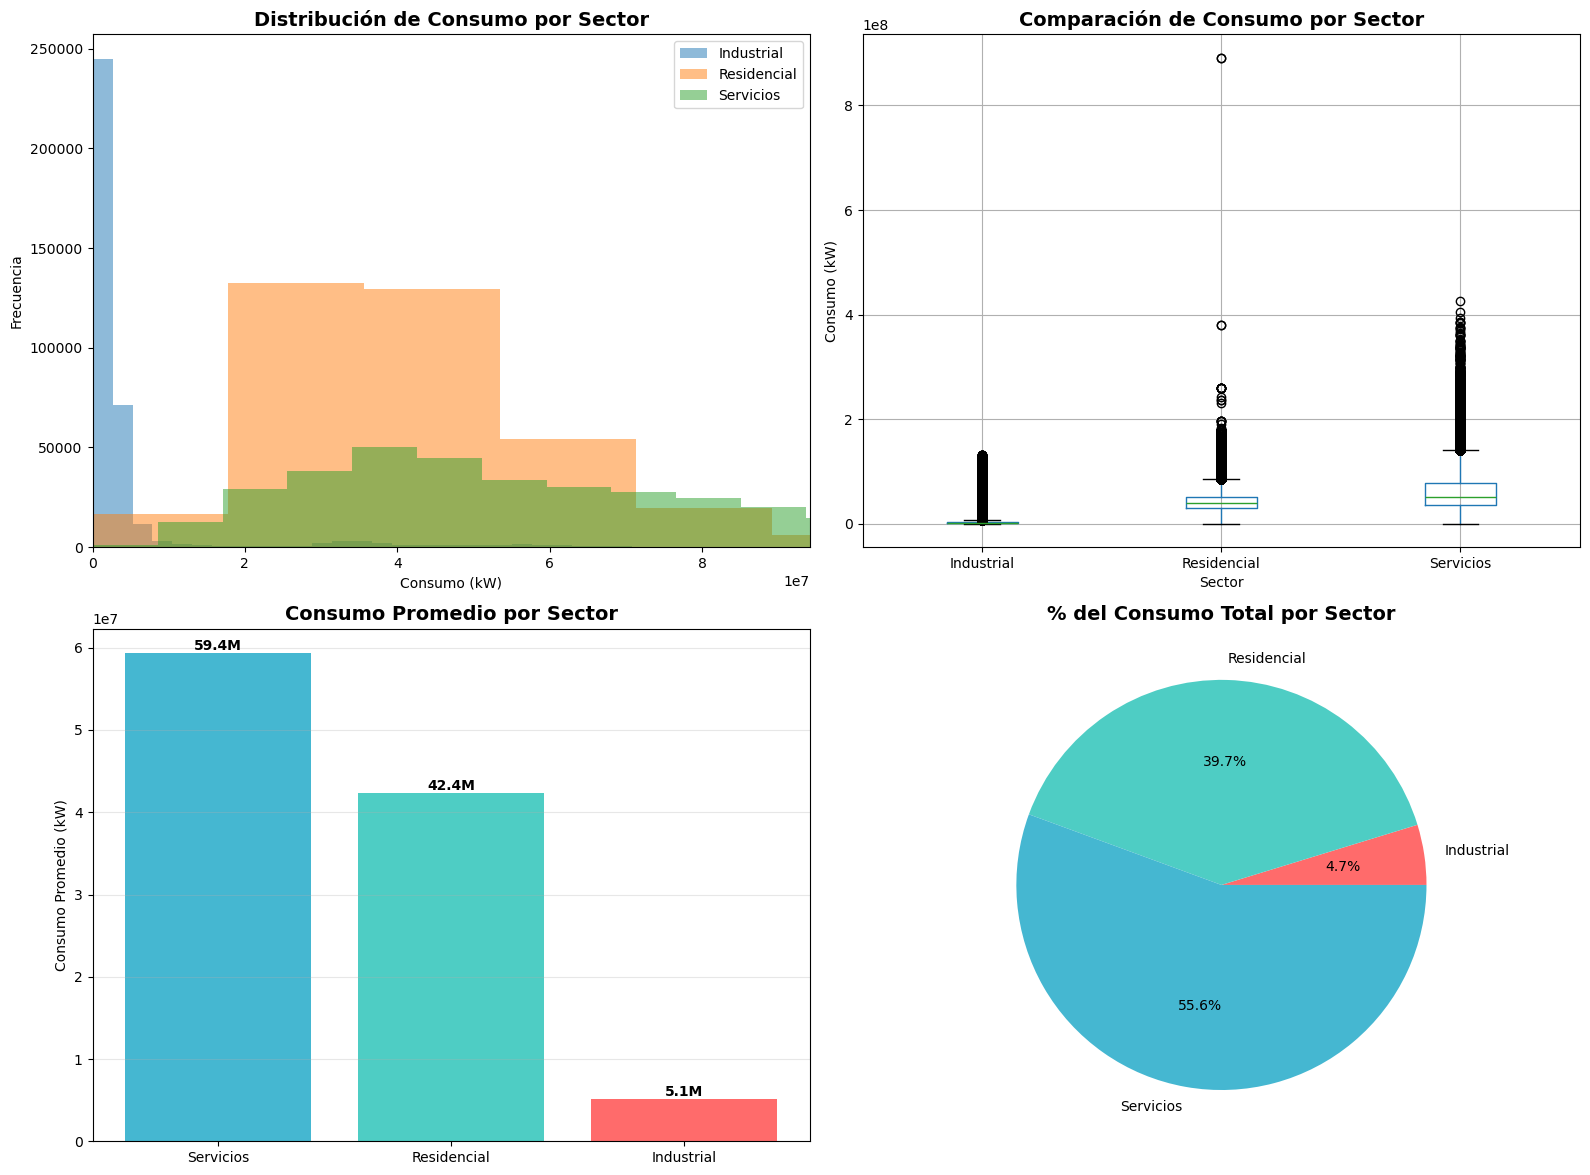

In [ ]:
# ============================================================================
# 1. COMPARACIÓN GENERAL ENTRE SECTORES
# ============================================================================

print("\n📊 1. PERFIL GENERAL DE CADA SECTOR")
print("=" * 80)

resumen_sectores = df.groupby('Sector_nombre').agg({
    'consumo_kwhhhh': ['count', 'mean', 'median', 'std', 'min', 'max'],
    'temperatura_media_ciudad': 'mean',
    'poblacion': 'mean'
}).round(2)

print("\n📈 Estadísticas por sector:")
print(resumen_sectores)

# Visualización comparativa
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Gráfico 1: Distribución de consumo por sector
ax1 = axes[0, 0]
for sector in ['Industrial', 'Residencial', 'Servicios']:
    data = df[df['Sector_nombre'] == sector]['consumo_kwhhh']
    ax1.hist(data, alpha=0.5, label=sector, bins=50)
ax1.set_xlabel('Consumo (kW)')
ax1.set_ylabel('Frecuencia')
ax1.set_title('Distribución de Consumo por Sector', fontsize=14, fontweight='bold')
ax1.legend()
ax1.set_xlim(0, df['consumo_kwhh'].quantile(0.95))  # Eliminar outliers extremos para visualización

# Gráfico 2: Boxplot comparativo
ax2 = axes[0, 1]
df.boxplot(column='consumo_kwhh', by='Sector_nombre', ax=ax2)
ax2.set_title('Comparación de Consumo por Sector', fontsize=14, fontweight='bold')
ax2.set_xlabel('Sector')
ax2.set_ylabel('Consumo (kW)')
plt.suptitle('')

# Gráfico 3: Consumo promedio por sector
ax3 = axes[1, 0]
consumo_medio = df.groupby('Sector_nombre')['consumo_kwhh'].mean().sort_values(ascending=False)
colors = {'Industrial': '#FF6B6B', 'Residencial': '#4ECDC4', 'Servicios': '#45B7D1'}
bars = ax3.bar(consumo_medio.index, consumo_medio.values, 
               color=[colors[s] for s in consumo_medio.index])
ax3.set_ylabel('Consumo Promedio (kW)')
ax3.set_title('Consumo Promedio por Sector', fontsize=14, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{height/1e6:.1f}M',
            ha='center', va='bottom', fontweight='bold')

# Gráfico 4: Porcentaje del consumo total
ax4 = axes[1, 1]
consumo_total = df.groupby('Sector_nombre')['consumo_kwhh'].sum()
ax4.pie(consumo_total, labels=consumo_total.index, autopct='%1.1f%%',
        colors=[colors[s] for s in consumo_total.index])
ax4.set_title('% del Consumo Total por Sector', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [8]:
# ============================================================================
# 2. ANÁLISIS INDIVIDUAL POR SECTOR
# ============================================================================

print("\n" + "=" * 80)
print("🔍 2. ANÁLISIS DETALLADO POR SECTOR")
print("=" * 80)

sectores = ['Industrial', 'Residencial', 'Servicios']
resultados_sectores = {}

for sector in sectores:
    print(f"\n{'='*80}")
    print(f"{'🏭' if sector == 'Industrial' else '🏠' if sector == 'Residencial' else '🏢'} SECTOR: {sector.upper()}")
    print(f"{'='*80}")
    
    # Filtrar datos del sector
    df_sector = df[df['Sector_nombre'] == sector].copy()
    
    print(f"\n📊 Registros: {len(df_sector):,}")
    print(f"   Consumo promedio: {df_sector['consumo_kwh'].mean():,.0f} kW")
    print(f"   Coef. variación: {(df_sector['consumo_kwh'].std() / df_sector['consumo_kwh'].mean() * 100):.1f}%")
    
    # ----- Análisis de variables para este sector -----
    
    # A. Tramo horario
    if 'ID_tramo_horario' in df_sector.columns:
        media_horario = df_sector.groupby('ID_tramo_horario')['consumo_kwh'].transform('mean')
        r2_horario = r2_score(df_sector['consumo_kwh'], media_horario)
        print(f"\n   ⏰ Tramo Horario → R² = {r2_horario:.4f} ({r2_horario*100:.2f}%)")
    
    # B. Temperatura
    if 'temperatura_media' in df_sector.columns:
        df_temp = df_sector[['temperatura_media', 'consumo_kwh']].dropna()
        if len(df_temp) > 0:
            corr_temp = df_temp['temperatura_media'].corr(df_temp['consumo_kwh'])
            r2_temp = corr_temp ** 2
            print(f"   🌡️  Temperatura → R² = {r2_temp:.4f} ({r2_temp*100:.2f}%), Corr = {corr_temp:.3f}")
    
    # C. Fin de semana
    if 'es_fin_de_semana' in df_sector.columns:
        media_fds = df_sector.groupby('es_fin_de_semana')['consumo_kwh'].transform('mean')
        r2_fds = r2_score(df_sector['consumo_kwh'], media_fds)
        print(f"   📅 Fin de Semana → R² = {r2_fds:.4f} ({r2_fds*100:.2f}%)")
        
        consumo_laboral = df_sector[~df_sector['es_fin_de_semana']]['consumo_kwh'].mean()
        consumo_fds = df_sector[df_sector['es_fin_de_semana']]['consumo_kwh'].mean()
        dif_fds = ((consumo_laboral - consumo_fds) / consumo_fds * 100)
        print(f"      → Diferencia laboral vs FDS: {dif_fds:+.1f}%")
    
    # D. Mes (estacionalidad)
    if 'mes' in df_sector.columns:
        media_mes = df_sector.groupby('mes')['consumo_kwh'].transform('mean')
        r2_mes = r2_score(df_sector['consumo_kwh'], media_mes)
        print(f"   🗓️  mes → R² = {r2_mes:.4f} ({r2_mes*100:.2f}%)")
        
        mes_max = df_sector.groupby('mes')['consumo_kwh'].mean().idxmax()
        mes_min = df_sector.groupby('mes')['consumo_kwh'].mean().idxmin()
        meses = {1:'Ene', 2:'Feb', 3:'Mar', 4:'Abr', 5:'May', 6:'Jun',
                 7:'Jul', 8:'Ago', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dic'}
        print(f"      → Mayor consumo: {meses[mes_max]}, Menor: {meses[mes_min]}")
    
    # E. Código postal
    if 'ID_geografia' in df_sector.columns:
        n_cp = df_sector['ID_geografia'].nunique()
        if n_cp > 1:
            media_cp = df_sector.groupby('ID_geografia')['consumo_kwh'].transform('mean')
            r2_cp = r2_score(df_sector['consumo_kwh'], media_cp)
            print(f"   📍 Código Postal ({n_cp} únicos) → R² = {r2_cp:.4f} ({r2_cp*100:.2f}%)")
    
    # Guardar resultados
    resultados_sectores[sector] = {
        'df': df_sector,
        'r2_horario': r2_horario if 'r2_horario' in locals() else 0,
        'r2_temp': r2_temp if 'r2_temp' in locals() else 0,
        'r2_fds': r2_fds if 'r2_fds' in locals() else 0,
        'r2_mes': r2_mes if 'r2_mes' in locals() else 0
    }


🔍 2. ANÁLISIS DETALLADO POR SECTOR

🏭 SECTOR: INDUSTRIAL

📊 Registros: 358,825
   Consumo promedio: 5,086,108 kW
   Coef. variación: 248.0%
   📅 Fin de Semana → R² = 0.0018 (0.18%)
      → Diferencia laboral vs FDS: +28.1%
   🗓️  mes → R² = 0.0017 (0.17%)
      → Mayor consumo: Jul, Menor: Dic

🏠 SECTOR: RESIDENCIAL

📊 Registros: 360,606
   Consumo promedio: 42,356,572 kW
   Coef. variación: 44.9%
   📅 Fin de Semana → R² = 0.0032 (0.32%)
      → Diferencia laboral vs FDS: +5.8%
   🗓️  mes → R² = 0.0784 (7.84%)
      → Mayor consumo: Ene, Menor: Oct

🏢 SECTOR: SERVICIOS

📊 Registros: 360,666
   Consumo promedio: 59,356,715 kW
   Coef. variación: 56.2%
   📅 Fin de Semana → R² = 0.0311 (3.11%)
      → Diferencia laboral vs FDS: +26.0%
   🗓️  mes → R² = 0.0425 (4.25%)
      → Mayor consumo: Jul, Menor: Abr



📊 3. COMPARACIÓN DE PATRONES ENTRE SECTORES


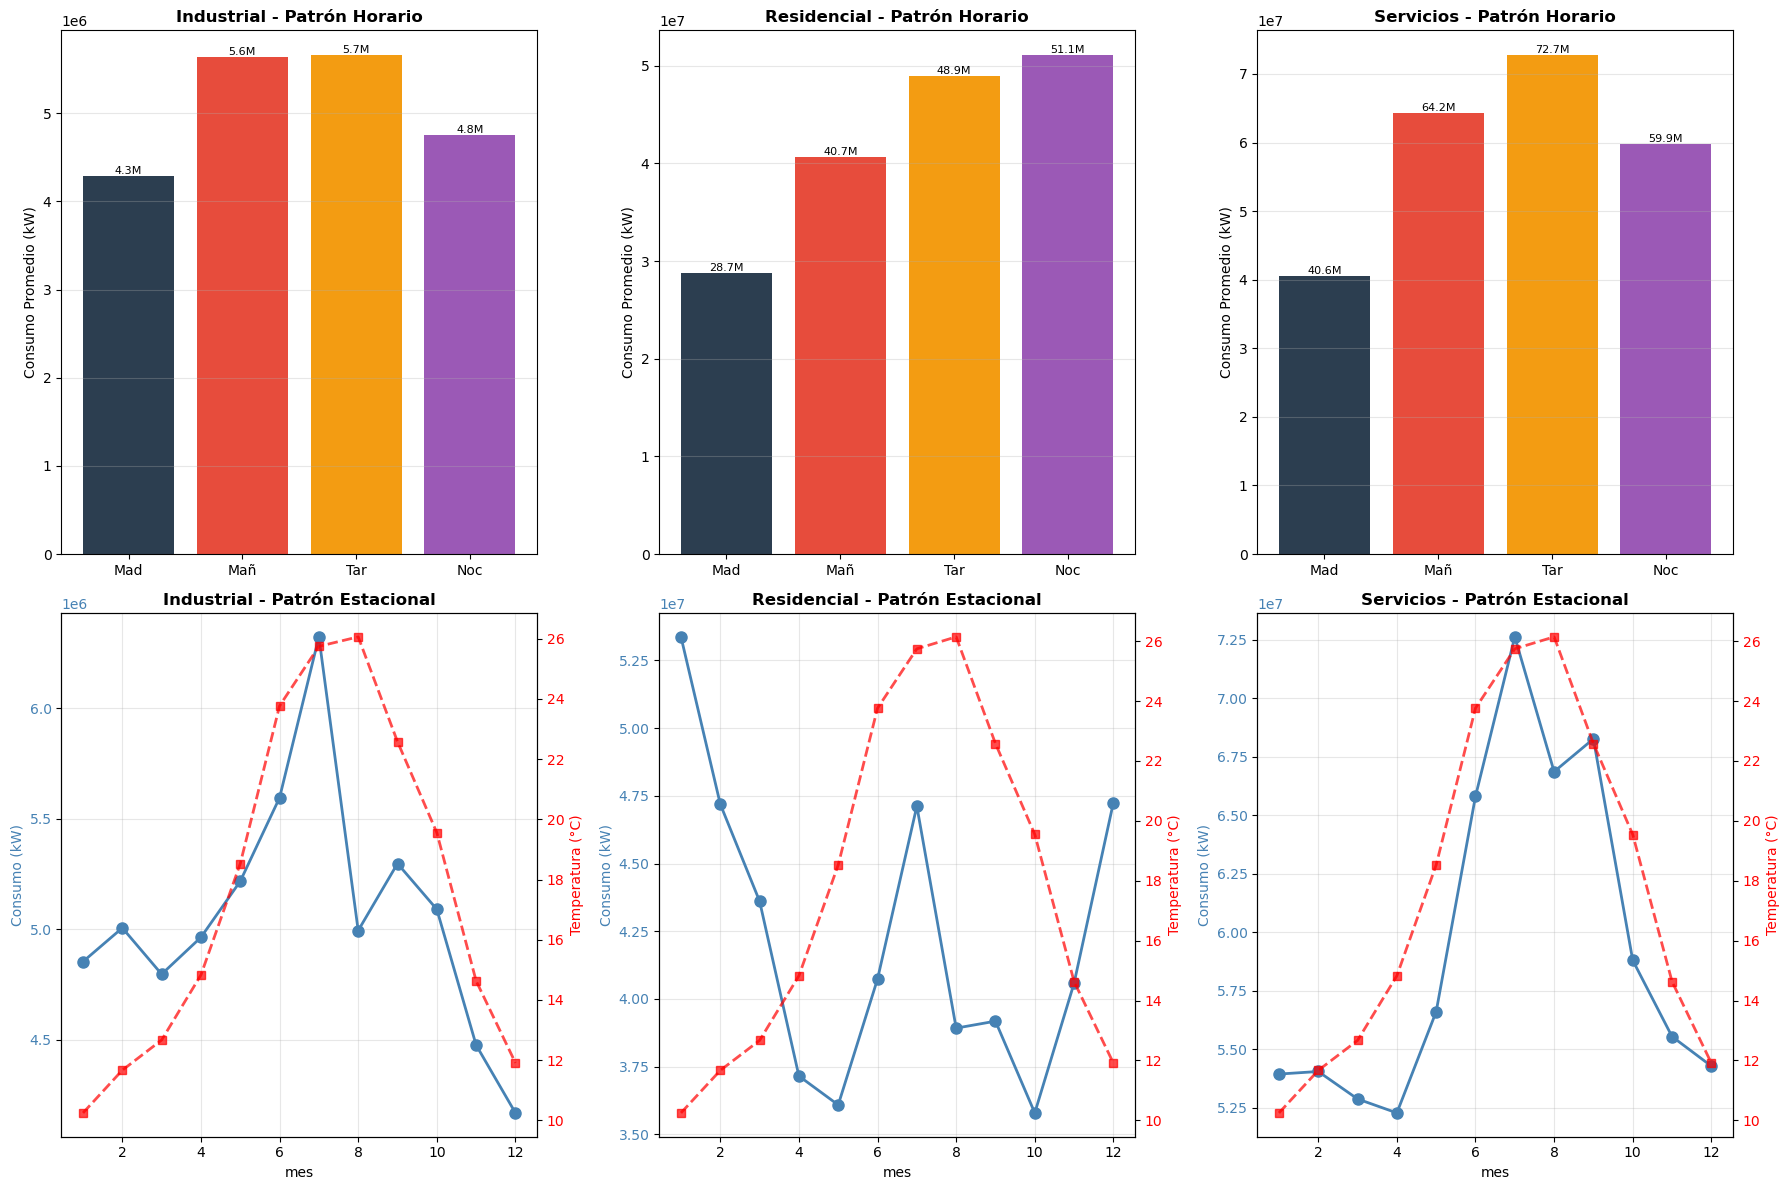

In [9]:
# ============================================================================
# 3. VISUALIZACIÓN COMPARATIVA DE PATRONES
# ============================================================================

print("\n" + "=" * 80)
print("📊 3. COMPARACIÓN DE PATRONES ENTRE SECTORES")
print("=" * 80)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Fila 1: Patrones horarios por sector
tramo_map = {1: 'Madrugada', 2: 'Mañana', 3: 'Tarde', 4: 'Noche'}

for idx, sector in enumerate(sectores):
    ax = axes[0, idx]
    df_sector = resultados_sectores[sector]['df']
    
    consumo_horario = df_sector.groupby('id_tramo_horario')['consumo_kwh'].mean()
    colors_horario = ['#2C3E50', '#E74C3C', '#F39C12', '#9B59B6']
    
    bars = ax.bar(range(1, 5), consumo_horario.values, color=colors_horario)
    ax.set_xticks(range(1, 5))
    ax.set_xticklabels(['Mad', 'Mañ', 'Tar', 'Noc'])
    ax.set_title(f'{sector} - Patrón Horario', fontweight='bold')
    ax.set_ylabel('Consumo Promedio (kW)')
    ax.grid(axis='y', alpha=0.3)
    
    # Añadir valores
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height/1e6:.1f}M',
                ha='center', va='bottom', fontsize=8)

# Fila 2: Patrones mensuales por sector
for idx, sector in enumerate(sectores):
    ax = axes[1, idx]
    df_sector = resultados_sectores[sector]['df']
    
    consumo_mensual = df_sector.groupby('mes')['consumo_kwh'].mean()
    temp_mensual = df_sector.groupby('mes')['temperatura_media_ciudad'].mean()
    
    # Consumo
    ax.plot(range(1, 13), consumo_mensual.values, marker='o', 
            linewidth=2, markersize=8, color='steelblue', label='Consumo')
    ax.set_xlabel('mes')
    ax.set_ylabel('Consumo (kW)', color='steelblue')
    ax.tick_params(axis='y', labelcolor='steelblue')
    ax.set_title(f'{sector} - Patrón Estacional', fontweight='bold')
    ax.grid(alpha=0.3)
    
    # Temperatura en eje secundario
    ax2 = ax.twinx()
    ax2.plot(range(1, 13), temp_mensual.values, marker='s',
             linewidth=2, markersize=6, color='red', linestyle='--', label='Temp', alpha=0.7)
    ax2.set_ylabel('Temperatura (°C)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

plt.tight_layout()
plt.show()


📊 4. SENSIBILIDAD DE CADA SECTOR A DIFERENTES FACTORES

🎯 Matriz de sensibilidad (% de varianza explicada):
               Industrial  Residencial  Servicios
Horario              0.00         0.00       0.00
Temperatura          0.00         0.00       0.00
Fin de Semana        0.18         0.32       3.11
Mes                  0.17         7.84       4.25


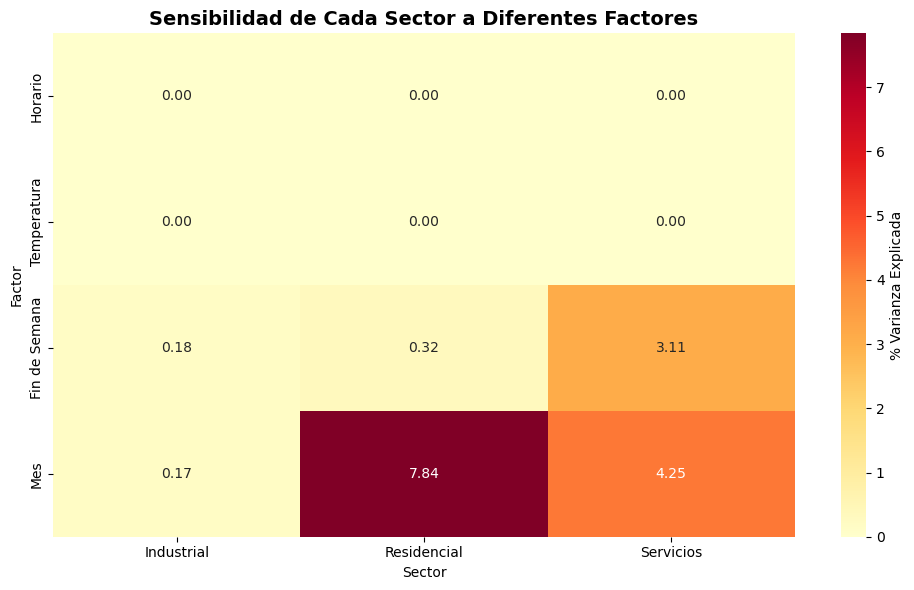

In [10]:
# ============================================================================
# 4. COMPARACIÓN DE SENSIBILIDAD A FACTORES
# ============================================================================

print("\n" + "=" * 80)
print("📊 4. SENSIBILIDAD DE CADA SECTOR A DIFERENTES FACTORES")
print("=" * 80)

# Crear matriz de sensibilidad
factores = ['Horario', 'Temperatura', 'Fin de Semana', 'Mes']
matriz_sensibilidad = pd.DataFrame(index=factores, columns=sectores)

for sector in sectores:
    res = resultados_sectores[sector]
    matriz_sensibilidad.loc['Horario', sector] = res['r2_horario'] * 100
    matriz_sensibilidad.loc['Temperatura', sector] = res['r2_temp'] * 100
    matriz_sensibilidad.loc['Fin de Semana', sector] = res['r2_fds'] * 100
    matriz_sensibilidad.loc['Mes', sector] = res['r2_mes'] * 100

matriz_sensibilidad = matriz_sensibilidad.astype(float)

print("\n🎯 Matriz de sensibilidad (% de varianza explicada):")
print(matriz_sensibilidad.round(2))

# Visualización del heatmap
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(matriz_sensibilidad, annot=True, fmt='.2f', cmap='YlOrRd', 
            cbar_kws={'label': '% Varianza Explicada'}, ax=ax)
ax.set_title('Sensibilidad de Cada Sector a Diferentes Factores', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Sector')
ax.set_ylabel('Factor')
plt.tight_layout()
plt.show()

In [11]:
# ============================================================================
# 5. MODELOS ESPECÍFICOS POR SECTOR
# ============================================================================

print("\n" + "=" * 80)
print("🤖 5. MODELOS PREDICTIVOS POR SECTOR")
print("=" * 80)

for sector in sectores:
    print(f"\n{'='*60}")
    print(f"SECTOR: {sector}")
    print(f"{'='*60}")
    
    df_sector = resultados_sectores[sector]['df']
    
    # Preparar features
    columnas_modelo = []
    for col in ['id_tramo_horario', 'id_geografia', 'mes', 'dia_del_mes',
                'es_fin_de_semana', 'es_festivo', 'temperatura_media_ciudad', 'humedad_media_ciudad']:
        if col in df_sector.columns:
            columnas_modelo.append(col)
    
    df_modelo = df_sector[columnas_modelo + ['consumo_kwh']].dropna()
    
    # Convertir booleanos
    for col in df_modelo.columns:
        if df_modelo[col].dtype == 'bool':
            df_modelo[col] = df_modelo[col].astype(int)
    
    if len(df_modelo) > 100:  # Solo si hay suficientes datos
        X = df_modelo[columnas_modelo]
        y = df_modelo['consumo_kwh']
        
        # Random Forest
        rf = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)
        rf.fit(X, y)
        r2_rf = rf.score(X, y)
        
        print(f"\n📊 R² del modelo: {r2_rf:.4f} ({r2_rf*100:.2f}%)")
        
        # Importancia de variables
        importancias = pd.DataFrame({
            'Variable': X.columns,
            'Importancia': rf.feature_importances_
        }).sort_values('Importancia', ascending=False)
        
        print(f"\n🎯 Top 5 variables más importantes:")
        print(importancias.head(5).to_string(index=False))


🤖 5. MODELOS PREDICTIVOS POR SECTOR

SECTOR: Industrial

📊 R² del modelo: 0.8508 (85.08%)

🎯 Top 5 variables más importantes:
                Variable  Importancia
            id_geografia     0.931387
temperatura_media_ciudad     0.013864
                     mes     0.012412
    humedad_media_ciudad     0.012315
        id_tramo_horario     0.011239

SECTOR: Residencial

📊 R² del modelo: 0.7566 (75.66%)

🎯 Top 5 variables más importantes:
                Variable  Importancia
            id_geografia     0.512203
        id_tramo_horario     0.294070
temperatura_media_ciudad     0.147493
                     mes     0.025655
        es_fin_de_semana     0.007833

SECTOR: Servicios

📊 R² del modelo: 0.7736 (77.36%)

🎯 Top 5 variables más importantes:
                Variable  Importancia
            id_geografia     0.646605
        id_tramo_horario     0.166704
temperatura_media_ciudad     0.091694
        es_fin_de_semana     0.067198
                     mes     0.010646


In [12]:
# ============================================================================
# 6. RECOMENDACIONES ESPECÍFICAS POR SECTOR
# ============================================================================

print("\n" + "=" * 80)
print("💡 6. RECOMENDACIONES ESPECÍFICAS")
print("=" * 80)

for sector in sectores:
    print(f"\n{'='*60}")
    print(f"🎯 {sector.upper()}")
    print(f"{'='*60}")
    
    res = resultados_sectores[sector]
    
    # Identificar el factor más importante
    factores_sector = {
        'Horario': res['r2_horario'],
        'Temperatura': res['r2_temp'],
        'Fin de Semana': res['r2_fds'],
        'Mes': res['r2_mes']
    }
    
    factor_max = max(factores_sector, key=factores_sector.get)
    r2_max = factores_sector[factor_max]
    
    print(f"\n✅ Factor más importante: {factor_max} (R² = {r2_max:.4f})")
    
    if sector == 'Industrial':
        print(f"\n📌 Recomendaciones:")
        print(f"   • Enfocar análisis en patrones de producción")
        print(f"   • Analizar días laborales vs festivos")
        print(f"   • Menos énfasis en temperatura (climatización menor)")
        
    elif sector == 'Residencial':
        print(f"\n📌 Recomendaciones:")
        print(f"   • Priorizar análisis de temperatura (calefacción/AC)")
        print(f"   • Analizar picos mañana y noche (rutinas domésticas)")
        print(f"   • Considerar tamaño de viviendas (población)")
        
    elif sector == 'Servicios':
        print(f"\n📌 Recomendaciones:")
        print(f"   • Analizar horarios comerciales")
        print(f"   • Temperatura importante (oficinas con AC)")
        print(f"   • Diferencia clara entre laborales y festivos")

print("\n" + "=" * 80)
print("✨ Análisis segmentado completado")
print("=" * 80)


💡 6. RECOMENDACIONES ESPECÍFICAS

🎯 INDUSTRIAL

✅ Factor más importante: Fin de Semana (R² = 0.0018)

📌 Recomendaciones:
   • Enfocar análisis en patrones de producción
   • Analizar días laborales vs festivos
   • Menos énfasis en temperatura (climatización menor)

🎯 RESIDENCIAL

✅ Factor más importante: Mes (R² = 0.0784)

📌 Recomendaciones:
   • Priorizar análisis de temperatura (calefacción/AC)
   • Analizar picos mañana y noche (rutinas domésticas)
   • Considerar tamaño de viviendas (población)

🎯 SERVICIOS

✅ Factor más importante: Mes (R² = 0.0425)

📌 Recomendaciones:
   • Analizar horarios comerciales
   • Temperatura importante (oficinas con AC)
   • Diferencia clara entre laborales y festivos

✨ Análisis segmentado completado
